# DeepMet: Training a human metabolite-likeness scorer

In this notebook, we demonstrate the training of a "metabolite-likeness" model. The model scores/classifies input compounds based on their structure similarity to the entire human metabolome. To provide an exemplar, we train a model based on the entire human metabolome and apply it to differentiate between metabolites and a set of non-metabolites from the ZINC12 database. We refer to the human metabolites as the "normal" class, whereas the non-metabolites are the "non-normal" class. DeepMet is essentially an outlier detection model applied to chemical structures.

The differentiation of molecules from HMDB and ZINC is rather large, so this is not a terribly difficult prediction task. However, we also had success creating likeness scorers for other compound classes, such as metabolite subclasses, lipid subclasses and toxic vs. non-toxic compounds. A benefit of using an unsupervised model like DeepMet, rather than a simple supervised two-class classifier, is that the one-class model is not biased to a particular "non-normal" compound type, but can be applied more broadly. It is also ideal in the instance where our "non-normal" class comprises a relatively small number of compounds.

In [3]:
import os
from shutil import copytree

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Draw

from sklearn.metrics import roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pyod.models import ocsvm, iforest
import torch

from deepmet.auxiliary import Config
from deepmet.structures import get_fingerprints_from_meta
from deepmet.datasets import load_training_dataset
from deepmet.workflows import train_single_model, train_likeness_scorer, get_likeness_scores

# Silence warnings
import warnings
warnings.filterwarnings("ignore")

# Notebook parameters
seed = 1
device = "cuda" if torch.cuda.is_available() else "cpu"
width, height = 7, 5  # Default plot size

## Data processing

We extracted compounds from the HMDB and ZINC12 databases, subject to the following constraints:
 - Exact mass filter: 100Da < exact mass \> 800Da
 - Heavy atom filter: heavy atoms \>= 4
 - RDKit molecular sanitization

For the purposes of this notebook, the entire set of compounds passing these filters in HMDB were retained while a random sample of 20,000 compounds were taken from ZINC12. The smiles for these compounds are available in the `deepmet/data/test_set` folder along with their respective compound IDs. For the development of the full model, we tested a larger number of ZINC12 compounds, in addition to compounds from other databases, such as Chembl and DrugBank. We also tested compound classes other than metabolites, such as lipids and toxic compounds.

Below, we create the folder `notebook_results` and make a copy of the compound lists. 

In [4]:
# Path to write results
results_path = os.path.join(os.path.dirname(os.path.abspath("")), "notebook_results")

if not os.path.exists(results_path):
    os.mkdir(results_path)

# Copy input data to the results folder
copytree(
    os.path.join(os.path.dirname(os.path.abspath("")), "deepmet", "data"),
    os.path.join(results_path, "data")
)

# Location of the "normal" and "non-normal" smiles
normal_meta_path, non_normal_meta_path = os.path.join(results_path, "data", "test_set", "hmdb_meta.csv"), os.path.join(results_path, "data", "test_set", "zinc_meta.csv")

Now we take the compound lists and convert them to molecular fingerprints (i.e., structure graphs are converted to a binary vector) which are used as input to the models.

In [5]:
# Takes the smiles and converts them to molecular fingerprints for each compound class
normal_fingerprints_path = get_fingerprints_from_meta(normal_meta_path, os.path.join(results_path, "data", "test_set", "hmdb_fingerprints.csv"))
non_normal_fingerprints_path = get_fingerprints_from_meta(non_normal_meta_path, os.path.join(results_path, "data", "test_set", "zinc_fingerprints.csv"))

Previously, we obtained the molecular data from relevant databases and created vectors describing their structural features (molecular fingerprints). Now, we create torch-compatible loaders using `load_training_dataset`. 

While we have generated the raw molecular fingerprints, these include many poorly balanced and redundant features. We therefore use `select_features` to these prior to model training. The function removes 0-variance features based on their variance in the training data

The data is then loaded into a torch-compatible loader using `load_training_dataset`. This takes the molecular features and their IDs and first performs feature selection to remove features with low-to-no variance. We define data splits for training (HMDB metabolites for model training), validation (HMDB metabolites used to optimise the models) and testing (HMDB metabolites and ZINC12 compounds unseen during the model development process). 

In [7]:
full_dataset, dataset_labels, train_val_dataset = load_training_dataset(
    normal_dataset_path=normal_fingerprints_path,
    normal_meta_path=normal_meta_path,
    non_normal_dataset_path=non_normal_fingerprints_path,
    non_normal_dataset_meta_path=non_normal_meta_path,
    seed=seed,
    validation_split=0.8,
    test_split=0.9
)

## Visualising chemical space

Below, we provide some basic visualisations of the chemical space spanned by the HMDB metabolites and compounds in the ZINC12 database. There are clear differences between the compound databases evident in these plots, indicating that this particular prediction task is not too challenging. This made the HMDB vs. ZINC comparison convenient for this exemplar, however it's worth noting that we were able to successfully apply DeepMet to more challenging tasks, such as differentiating metabolite sub-classes and differentiating between toxic and non-toxic compounds.

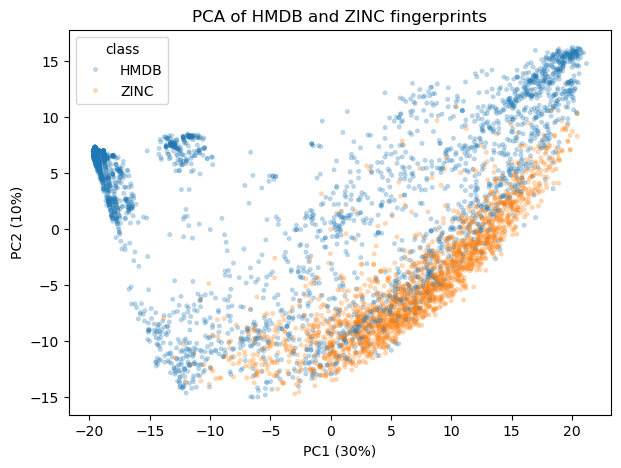

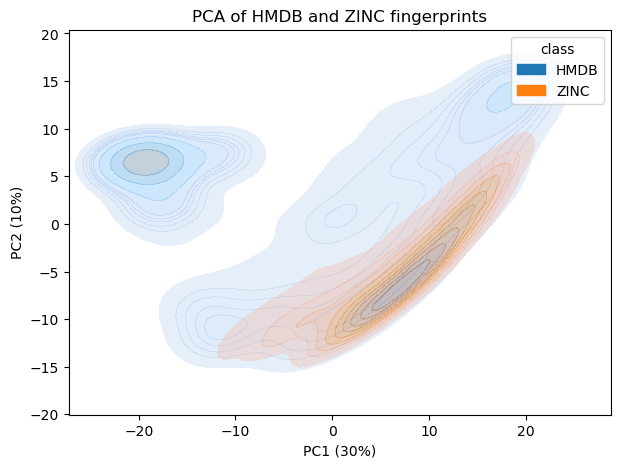

In [8]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(full_dataset.train_set.dataset.data)
df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
df["class"] = full_dataset.train_set.dataset.labels
df["class"] = df["class"].map({0: "HMDB", 1: "ZINC"})


def plot_embedding(model, pca_df, title, hue="class", hue_order=["HMDB", "ZINC"], frac=0.1, s=10, alpha=0.3, edgecolor=None, **kwargs):
    """
    Plots a scatter and KDE plot for the PCA or t-SNE embedding

    Parameters:
        model (PCA or TSNE): The model used to embed the data
        pca_df (pd.DataFrame): The data
        title (str): The title of the plot
        hue (str): The column of the data to use for the color of the points
        frac (float): The fraction of the data to plot in the scatter plot
        s (int): The size of the points
        alpha (float): The transparency of the points
        edgecolor (str): The color of the edge of the points
        **kwargs: Additional keyword arguments for the scatter plot
    """

    pca_df = pca_df.sample(frac=1).reset_index(drop=True)
    pca_df_sample = pca_df.sample(frac=frac).reset_index(drop=True)

    x_var = "PC1" if isinstance(model, PCA) else "tSNE1"
    y_var = "PC2" if isinstance(model, PCA) else "tSNE2"
    x_lab = f"PC1 ({(model.explained_variance_ratio_[0] * 100):.0f}%)" if isinstance(model, PCA) else x_var
    y_lab = f"PC2 ({(model.explained_variance_ratio_[1] * 100):.0f}%)" if isinstance(model, PCA) else y_var

    plt.figure(figsize=(width, height))
    sns.scatterplot(data=pca_df_sample, x=x_var, y=y_var, hue=hue, hue_order=hue_order, s=s, alpha=alpha, edgecolor=edgecolor, **kwargs)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.title(title)

    plt.figure(figsize=(width, height))
    sns.kdeplot(data=pca_df, x=x_var, y=y_var, hue=hue, hue_order=hue_order, fill=True, common_norm=False, alpha=alpha, levels=10)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.title(title)

plot_embedding(pca, df, title="PCA of HMDB and ZINC fingerprints", hue="class", hue_order=["HMDB", "ZINC"])

tSNE - HMDB (metabolite) vs. ZINC (non-metabolite)

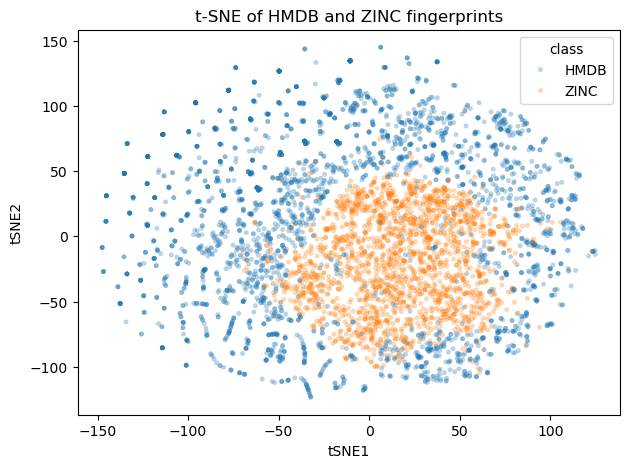

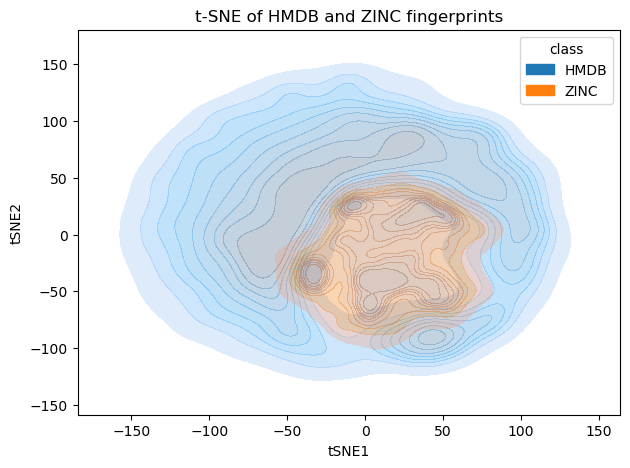

In [9]:
# tSNE plot
tsne = TSNE(n_components=2, random_state=seed)
tsne_result = tsne.fit_transform(full_dataset.train_set.dataset.data)

df = pd.DataFrame(tsne_result, columns=["tSNE1", "tSNE2"])
df["class"] = full_dataset.train_set.dataset.labels
df["class"] = df["class"].map({0: "HMDB", 1: "ZINC"})

plot_embedding(tsne, df, title="t-SNE of HMDB and ZINC fingerprints", hue="class", hue_order=["HMDB", "ZINC"])

## Training DeepMet

The DeepMet package is based on the DeepSVDD model developed by Ruff et al., 2018:
 - GitHub: https://github.com/lukasruff/Deep-SVDD-PyTorch
 - ICML paper: http://proceedings.mlr.press/v80/ruff18a.html

The authors demonstrate the model for the detection of anomalous images. DeepMet uses the DeepSVDD approach to identify anomalous compounds - specifically, we trained the model on metabolites to generate "metabolite-likeness" scores. DeepMet does, however, allow users to re-train the model for any class of compounds; therefore, likeness scores can be generated for any type of structures.

We use a set transformer architecture developed by Lee et al., 2019 (http://proceedings.mlr.press/v97/lee19d.html), which was also used by Vriza et al., 2020 (https://pubs.rsc.org/en/content/articlelanding/2021/sc/d0sc04263c) to predict co-crystal pairs.

There are two key workflows in the DeepMet package:
 - `train_likeness_scorer`: implements the workflow for training a DeepMet model
 - `get_likeness_scores`: uses a pre-trained DeepMet model to generate metabolite-likeness scores for new compounds

For the purposes of this vignette, we will first carry out the individual steps of the `train_likeness_scorer` workflow manually. Then, we will generate an identical model using `train_likeness_scorer` and compare it to two other one-class classification algorithms. Finally, we will take the stored model weights and those of the full model generated in the DeepMet paper and re-score the subset of compounds using `get_likeness_scores`.

Below, we set the training options for the DeepMet model. Previously, these were determined based on a random grid search of possible hyperparameters in order to minimise the model's loss on the validation set. Here, we simply use the optimal parameters to train a single model. 

In [10]:
# Settings required by the DeepMet model
cfg = Config({
    "net_name": "cocrystal_transformer",
    "objective": "one-class",
    "nu": 0.1,
    "rep_dim": 200,
    "seed": seed,
    "optimizer_name": "amsgrad",
    "lr": 0.000155986,
    "n_epochs": 20,
    "lr_milestones": tuple(),
    "batch_size": 25,
    "weight_decay": 1e-5,
    "pretrain": False,
    "in_features": 2800,
    "device": device
})

With the dataset loaded, we can now train the model. We can use AUC to evaluate the model's discriminative capacity for metabolites vs ZINC12 compounds - but, importantly, AUC was not used for hyperparameter optimisation as the validation set does not contain any "non-normal" compounds. Additionally, we calculate the AUC based on HMDB metabolites that were no

In [11]:
# Train the model (loss is calculated on the 'normal' validation set for parameter tuning)
deep_met_model = train_single_model(cfg, train_val_dataset)

# Test using separate test dataset (includes the ZINC12 set of 'non-normal' compounds)
deep_met_model.test(full_dataset)

initial_auc = round(deep_met_model.results["test_auc"], 4)
print("AUC on test set: " + str(initial_auc))

AUC on test set: 0.9886


Instead of going through each of these steps, the `train_likeness_scorer` function can train a model from scratch from the original smiles. Here, we re-train the model using the same settings as above and the pre-calculated fingerprints.

In [12]:
deep_met_model = train_likeness_scorer(
    normal_meta_path=normal_meta_path,
    non_normal_meta_path=non_normal_meta_path,
    normal_fingerprints_path=normal_fingerprints_path,
    non_normal_fingerprints_path=non_normal_fingerprints_path,
    results_path=results_path,
    net_name=cfg.settings["net_name"],
    objective=cfg.settings["objective"],
    nu=cfg.settings["nu"],
    rep_dim=cfg.settings["rep_dim"],
    device=cfg.settings["device"],
    seed=seed,
    optimizer_name=cfg.settings["optimizer_name"],
    lr=cfg.settings["lr"],
    n_epochs=cfg.settings["n_epochs"],
    lr_milestones=cfg.settings["lr_milestones"],
    batch_size=cfg.settings["batch_size"],
    weight_decay=cfg.settings["weight_decay"],
    validation_split=0.8,
    test_split=0.9
)

INFO:root:Log file is /mnt/c/Users/Jack Gisby/OneDrive/Documents/Work/Imperial_PhD/Side_projects/DeepMet/scripting/deepmet/notebook_results/log.txt.
INFO:root:Export path is /mnt/c/Users/Jack Gisby/OneDrive/Documents/Work/Imperial_PhD/Side_projects/DeepMet/scripting/deepmet/notebook_results.
INFO:root:Network: cocrystal_transformer
INFO:root:The filtered normal fingerprint matrix path is /mnt/c/Users/Jack Gisby/OneDrive/Documents/Work/Imperial_PhD/Side_projects/DeepMet/scripting/deepmet/notebook_results/normal_fingerprints_processed.csv.
INFO:root:The filtered normal meta is /mnt/c/Users/Jack Gisby/OneDrive/Documents/Work/Imperial_PhD/Side_projects/DeepMet/scripting/deepmet/notebook_results/data/test_set/hmdb_meta.csv.
INFO:root:The filtered non-normal fingerprint matrix path is /mnt/c/Users/Jack Gisby/OneDrive/Documents/Work/Imperial_PhD/Side_projects/DeepMet/scripting/deepmet/notebook_results/non_normal_fingerprints_processed.csv.
INFO:root:The filtered non-normal meta is /mnt/c/User

We see that the model, despite not being directly trained to differentiate between human metabolites (HMDB) and other compounds (ZINC12), is nevertheless able to distinguish between them very well. 

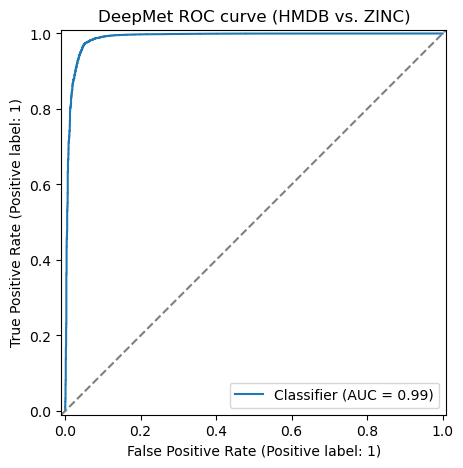

In [13]:
def plot_display(y_hat, y_true, display_class, identity_line=False, figsize=(3.3, 3.3), **kwargs):
    """
    Creates a scikit-learn display class from predictions and true labels and returns
    the figure object. The display class can include ROC, PR, and confusion matrix plots.

    Parameters:
        y_hat (np.array): Array of predicted probabilities or labels.
        y_true (np.array): Array of true labels.
        display_class (class): Class to use for plotting the diagnostic curve.
        identity_line (bool): Whether to plot the identity line.
        figsize (tuple): Size of the figure.
        **kwargs: Additional keyword arguments to pass to the display class.

    Returns:
        matplotlib.figure.Figure: The figure containing the diagnostic curve.
    """

    display = display_class.from_predictions(
        y_true,
        y_hat,
        **kwargs
    )

    if identity_line:
        display.ax_.axline((0, 0), slope=1, color="grey", linestyle="--")

    fig = display.ax_.get_figure() 
    fig.set_figwidth(figsize[0])
    fig.set_figheight(figsize[1])  

    return fig

# get the scores for the test set
deep_met_scores = [c[2] for c in deep_met_model.results["test_scores"]]

# make ROC curve
plot_display(
    deep_met_scores,
    full_dataset.test_set.dataset.labels[full_dataset.test_set.indices],
    RocCurveDisplay,
    identity_line=True,
    figsize=(width, height)
)
plt.title("DeepMet ROC curve (HMDB vs. ZINC)") 
plt.show()

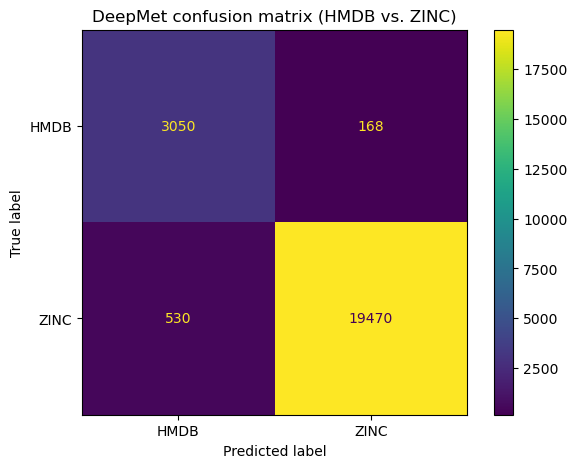

In [14]:
def get_preds(scores, labels):
    """
    Uses the scores and labels to determine the optimal threshold for classification
    using Youden's Index.

    Parameters:
        scores (np.array): Array of predicted scores.
        labels (np.array): Array of true labels.

    Returns:
        np.array: Array of predicted labels.
    """

    fpr, tpr, thresholds = roc_curve(labels, scores)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    preds = [1 if score > optimal_threshold else 0 for score in scores]
    return preds

deep_met_preds = get_preds(deep_met_scores, full_dataset.test_set.dataset.labels[full_dataset.test_set.indices])

# plot predictions as confusion matrix
plot_display(
    deep_met_preds,
    full_dataset.test_set.dataset.labels[full_dataset.test_set.indices],
    ConfusionMatrixDisplay,
    figsize=(width, height),
    display_labels=["HMDB", "ZINC"]
)
plt.title("DeepMet confusion matrix (HMDB vs. ZINC)") 
plt.show()

We can visualise the embeddings of the model. DeepMet is based on the DeepSVDD approach, meaning that the model attempts to map the data to a hypersphere of minimum volume. This can be observed visually in the plots below.

INFO:root:Starting embedding...


INFO:root:Embedding time: 4.284
INFO:root:Finished embedding.


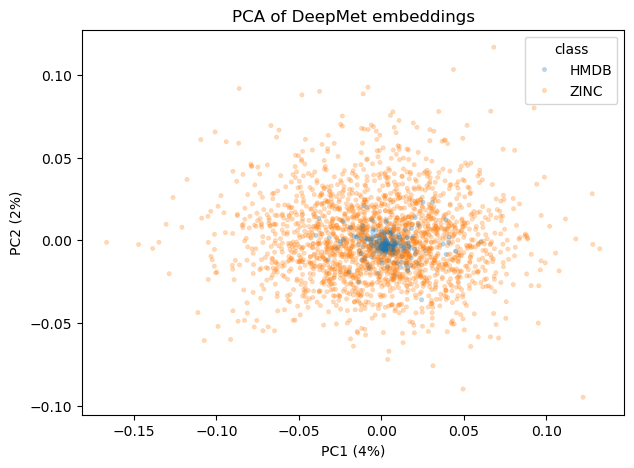

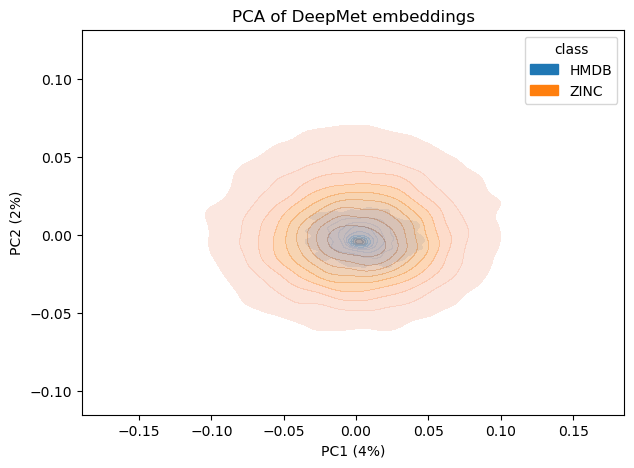

In [15]:
# visualise the output embedding layer of the model
embeddings = deep_met_model.get_embedding(full_dataset)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
df["class"] = full_dataset.test_set.dataset.labels[full_dataset.test_set.indices]
df["class"] = df["class"].map({0: "HMDB", 1: "ZINC"})

plot_embedding(pca, df, title="PCA of DeepMet embeddings", hue="class", hue_order=["HMDB", "ZINC"])

## Benchmarking models

Below, we train isolation forest (IF) and one-class SVM (OC-SVM) models based on the data we used for training DeepMet. We determined the optimal parameters using random grid search, in a manner similar to the optimisation of DeepMet. Again, these are trained only on the metabolite (HMDB) data to create generaliseable models of the "normal" class, before testing whether the metabolite-likeness scorers are able to differentiate between the HMDB- and ZINC-derived compounds.

See pyod for more information on these models see `pyod`: https://pyod.readthedocs.io/en/latest/

In [16]:
iforest_model = iforest.IForest(
    contamination=0.1,
    n_estimators=400,
    behaviour="new",
    random_state=seed,
    max_samples=1000
)

ocsvm_model = ocsvm.OCSVM(
    contamination=0.1,
    kernel="rbf",
    nu=0.1,
    gamma=0.00386
)

x_train = train_val_dataset.train_set.dataset.data[train_val_dataset.train_set.indices]

iforest_model.fit(x_train)
ocsvm_model.fit(x_train)

OCSVM(cache_size=200, coef0=0.0, contamination=0.1, degree=3, gamma=0.00386,
   kernel='rbf', max_iter=-1, nu=0.1, shrinking=True, tol=0.001,
   verbose=False)

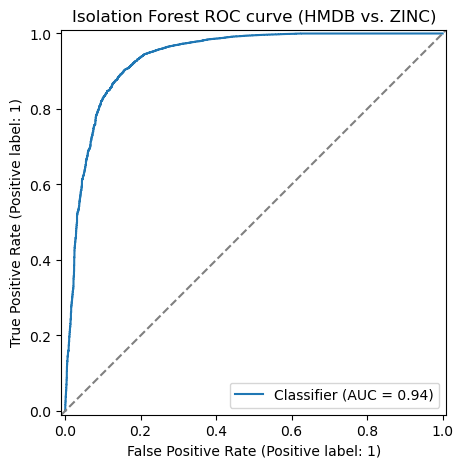

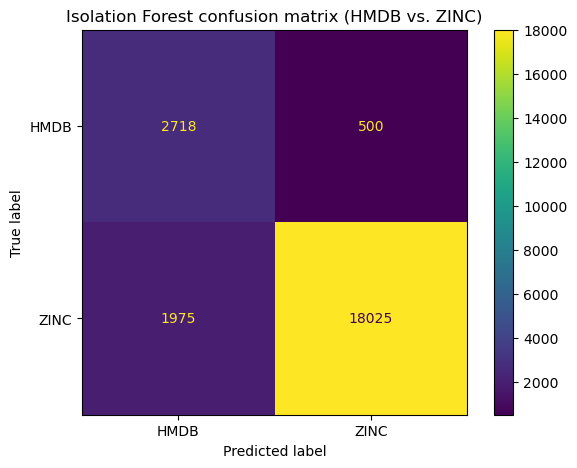

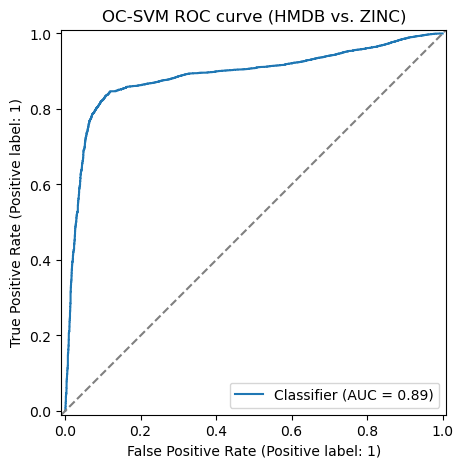

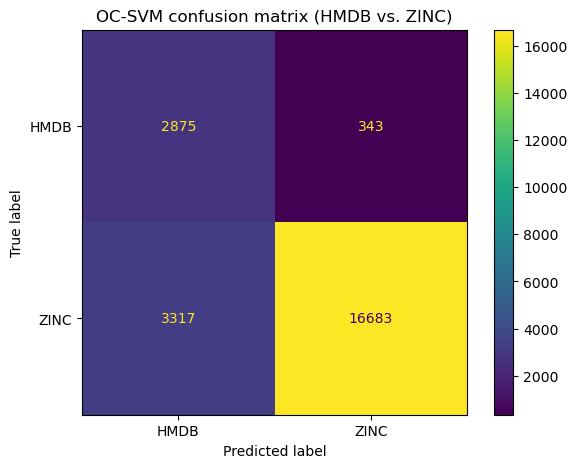

In [17]:
x_test = full_dataset.test_set.dataset.data[full_dataset.test_set.indices]
labels_test = full_dataset.test_set.dataset.labels[full_dataset.test_set.indices]

plot_display(
    iforest_model.decision_function(x_test),
    labels_test,
    RocCurveDisplay,
    identity_line=True,
    figsize=(width, height)
)
plt.title("Isolation Forest ROC curve (HMDB vs. ZINC)")
plt.show()

plot_display(
    get_preds(iforest_model.decision_function(x_test), labels_test),
    labels_test,
    ConfusionMatrixDisplay,
    figsize=(width, height),
    display_labels=["HMDB", "ZINC"]
)
plt.title("Isolation Forest confusion matrix (HMDB vs. ZINC)")
plt.show()

plot_display(
    ocsvm_model.decision_function(x_test),
    labels_test,
    RocCurveDisplay,
    identity_line=True,
    figsize=(width, height)
)
plt.title("OC-SVM ROC curve (HMDB vs. ZINC)")
plt.show()

plot_display(
    get_preds(ocsvm_model.decision_function(x_test), labels_test),
    labels_test,
    ConfusionMatrixDisplay,
    figsize=(width, height),
    display_labels=["HMDB", "ZINC"]
)
plt.title("OC-SVM confusion matrix (HMDB vs. ZINC)")
plt.show()

We can see a comparison of the distribution of the decision functions for each of the models split by the compound database. As we expect based on the AUC, the DeepMet scores better differentiate between the HMDB and ZINC12 compounds. 

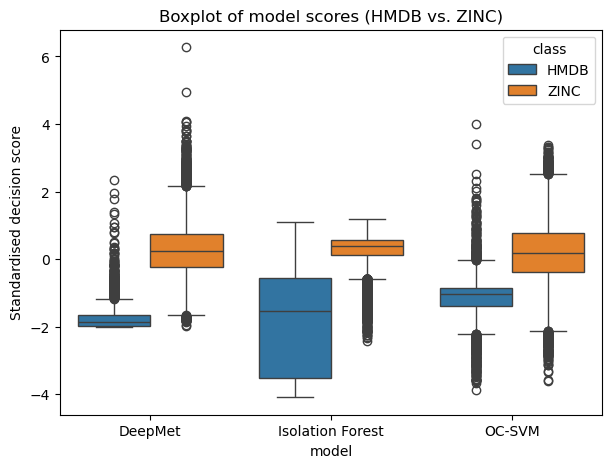

In [18]:
scores = {
    "DeepMet": deep_met_scores,
    "Isolation Forest": iforest_model.decision_function(x_test),
    "OC-SVM": ocsvm_model.decision_function(x_test)
}

df = pd.DataFrame(scores)
df["class"] = full_dataset.test_set.dataset.labels[full_dataset.test_set.indices]
df["class"] = df["class"].map({0: "HMDB", 1: "ZINC"})
df = df.melt(id_vars="class", var_name="model", value_name="score")

# Scale scores by model
df["score"] = (df["score"] - df.groupby("model")["score"].transform("mean")) / df.groupby("model")["score"].transform("std")

plt.figure(figsize=(width, height))
sns.boxplot(data=df, x="model", y="score", hue="class")
plt.title("Boxplot of model scores (HMDB vs. ZINC)")
plt.ylabel("Standardised decision score")
plt.show()

## Visualising decision spaces

Below, we visualise the decision values (essentially raw metabolite-likeness scores) in PC-space. We recreate the principal component plot but additionally use colour to indicate the decision values. We do this by creating a grid in PC-space, transforming it back to the original feature values, and applying the models to these. 

/home/jackgisby/miniconda3/envs/deepmet/lib/python3.12/site-packages/deepmet/core.py:249: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_path)
I

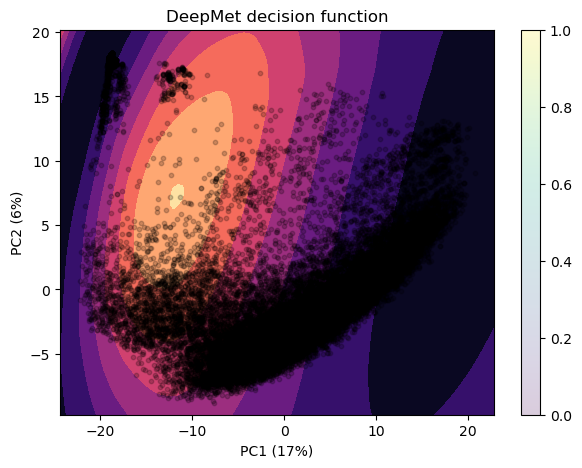

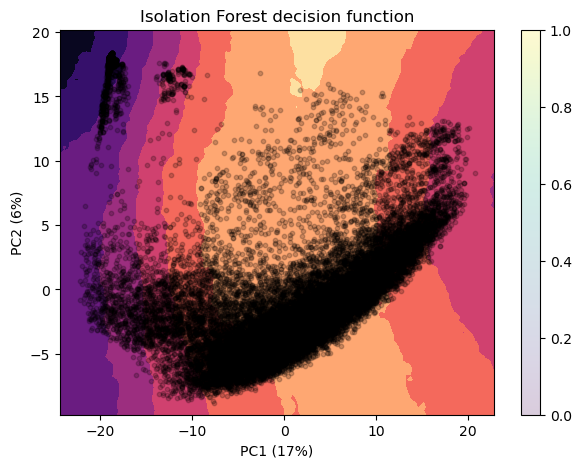

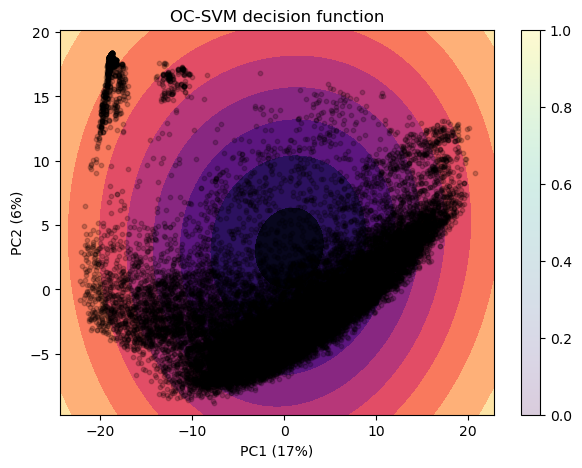

In [94]:
# Visualise decision functions via PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(full_dataset.test_set.dataset.data[full_dataset.test_set.indices])

# Define grid in PC-space and transform back to fingerprint space
multiply_space = 1.1
grid_size = 100

xx, yy = np.meshgrid(
    np.linspace(pca_result[:, 0].min()* multiply_space, pca_result[:, 0].max()* multiply_space, grid_size),
    np.linspace(pca_result[:, 1].min()* multiply_space, pca_result[:, 1].max()* multiply_space, grid_size)
)

xxs, yys = xx.ravel(), yy.ravel()

pc_grid = np.matrix([xxs, yys]).T
pc_meta = np.matrix([
    range(len(xxs)),
    [""] * len(xxs),
    [0.0] * len(xxs)
]).T

combined_pc_grid = np.column_stack((pc_meta, pc_grid))
transformed_grid = pca.inverse_transform(pc_grid)
np.savetxt("pcs_meta.csv", combined_pc_grid, delimiter=",", fmt='%s')
np.savetxt("pcs_fingerprints.csv", transformed_grid, delimiter=",")

deep_met_pc_scores = get_likeness_scores(
    dataset_path="pcs_meta.csv", 
    results_path=results_path,
    load_model=os.path.join(results_path, "model.tar"),
    load_config=os.path.join(results_path, "config.json"),
    input_fingerprints_path="pcs_fingerprints.csv",
    filter_features=False
)

# Get decision function for grid for plotting on PCA plot
scores = {
    "DeepMet": np.array([s[2] for s in deep_met_pc_scores]),
    "Isolation Forest": iforest_model.decision_function(np.asarray(transformed_grid)),
    "OC-SVM": ocsvm_model.decision_function(np.asarray(transformed_grid))
}

# Make PC plots with decision functions overlaid as contours
for model_name in scores.keys():
    plt.figure(figsize=(width, height))
    plt.contourf(xx, yy, scores[model_name].reshape(xx.shape), alpha=1, cmap="magma")
    plt.scatter(pca_result[:, 0], pca_result[:, 1], s=10, alpha=0.2, c="black")
    plt.colorbar()
    plt.title(f"{model_name} decision function")
    plt.xlabel(f"PC1 ({(pca.explained_variance_ratio_[0] * 100):.0f}%)")
    plt.ylabel(f"PC2 ({(pca.explained_variance_ratio_[1] * 100):.0f}%)")
    plt.show()

## Metabolite-like and outlier molecules

We can look at the specific chemical structures labelled as highly "metabolite-like" and those that are labelled as outliers. 

In [89]:
# Get scored smiles for HMDB
hmdb_smiles_scores = get_likeness_scores(
    dataset_path=os.path.join(results_path, "data", "test_set", "hmdb_meta.csv"),
    results_path=results_path,
    load_model=os.path.join(results_path, "model.tar"),
    load_config=os.path.join(results_path, "config.json"),
    input_fingerprints_path=os.path.join(results_path, "data", "test_set", "hmdb_fingerprints.csv")
)

# Get smiles for 6 highest and lowest scoring compounds in HMDB
hmdb_smiles_scores.sort(key=lambda x: x[2])
hmdb_min_scores = hmdb_smiles_scores[:6] 
hmdb_max_scores = hmdb_smiles_scores[-6:] 

min_score_hmdb_mols = [Chem.MolFromSmiles(score_tuple[1]) for score_tuple in hmdb_min_scores]
max_score_hmdb_mols = [Chem.MolFromSmiles(score_tuple[1]) for score_tuple in hmdb_max_scores]

/home/jackgisby/miniconda3/envs/deepmet/lib/python3.12/site-packages/deepmet/core.py:249: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_path)
I

Below, we see the highly metabolite-like chemical structures according to DeepMet. The most "metabolite-like" metabolites tend to be lipids, which are highly represented in the HMDB database and have very similar fingerprints.

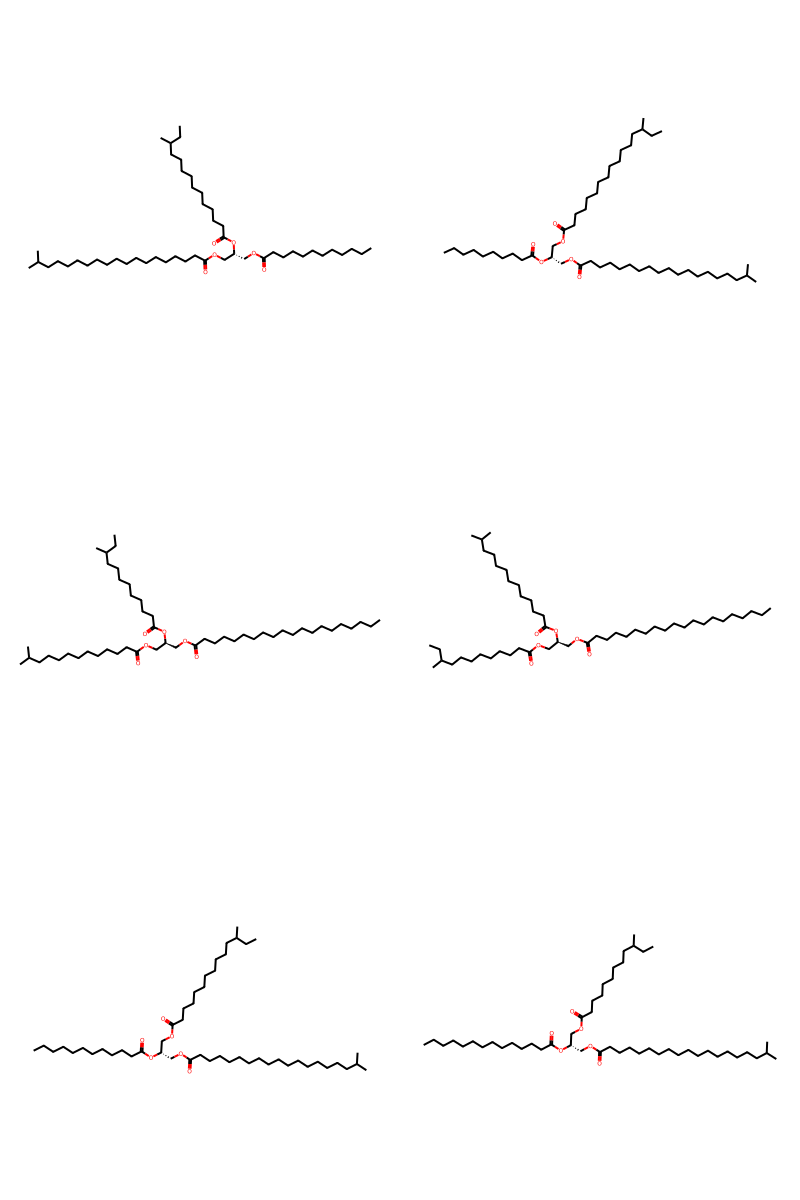

In [90]:
Draw.MolsToGridImage(min_score_hmdb_mols, molsPerRow=2, subImgSize=(400, 400))

Below, we see the HMDB structures that are considered relatively un-metabolite-like. These tend to include atoms that are rare for metabolites (e.g., Br, Cl, Sn) and/or unusual bonding patterns.

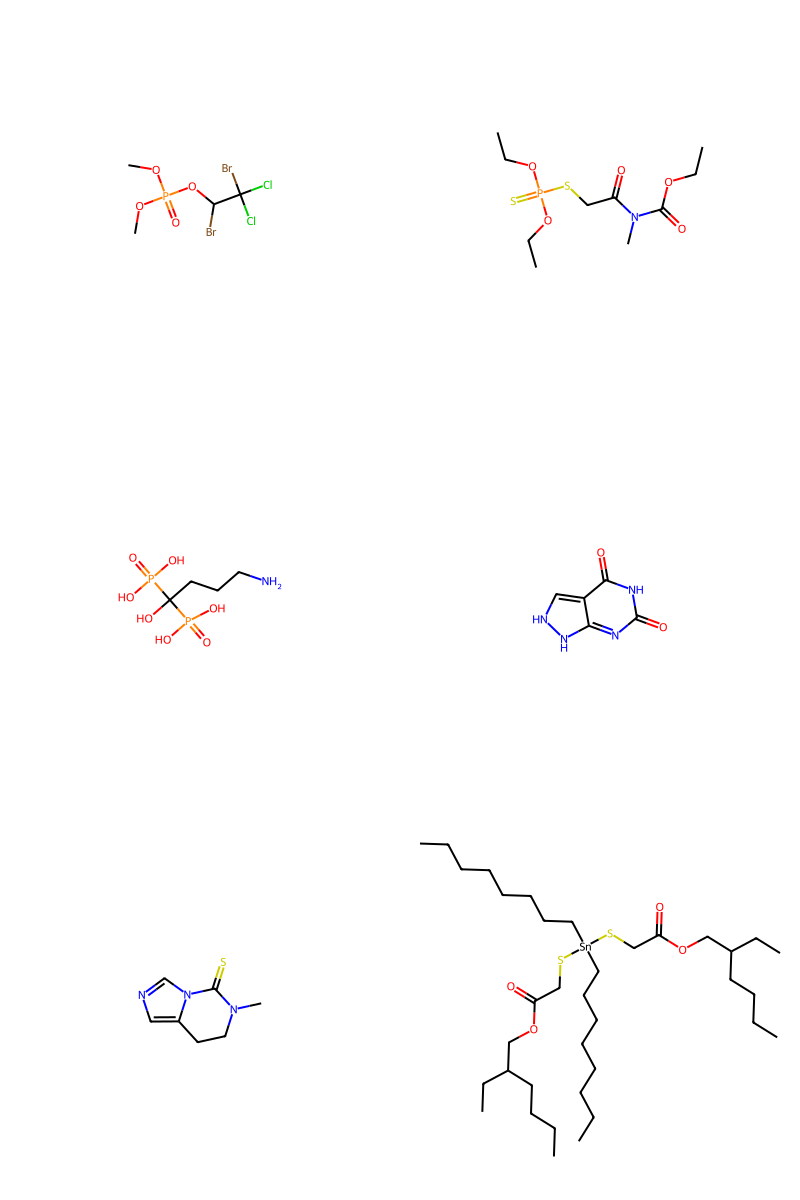

In [91]:
Draw.MolsToGridImage(max_score_hmdb_mols, molsPerRow=2, subImgSize=(400, 400))

We can also look at structures that are highly metabolite-like in the ZINC database. These include simply hydrocarbons, lipid-like molecules and steroid structures; all of these are either similar to recorded human metabolites or are compounds that are also in HMDB.

/home/jackgisby/miniconda3/envs/deepmet/lib/python3.12/site-packages/deepmet/core.py:249: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_path)
I

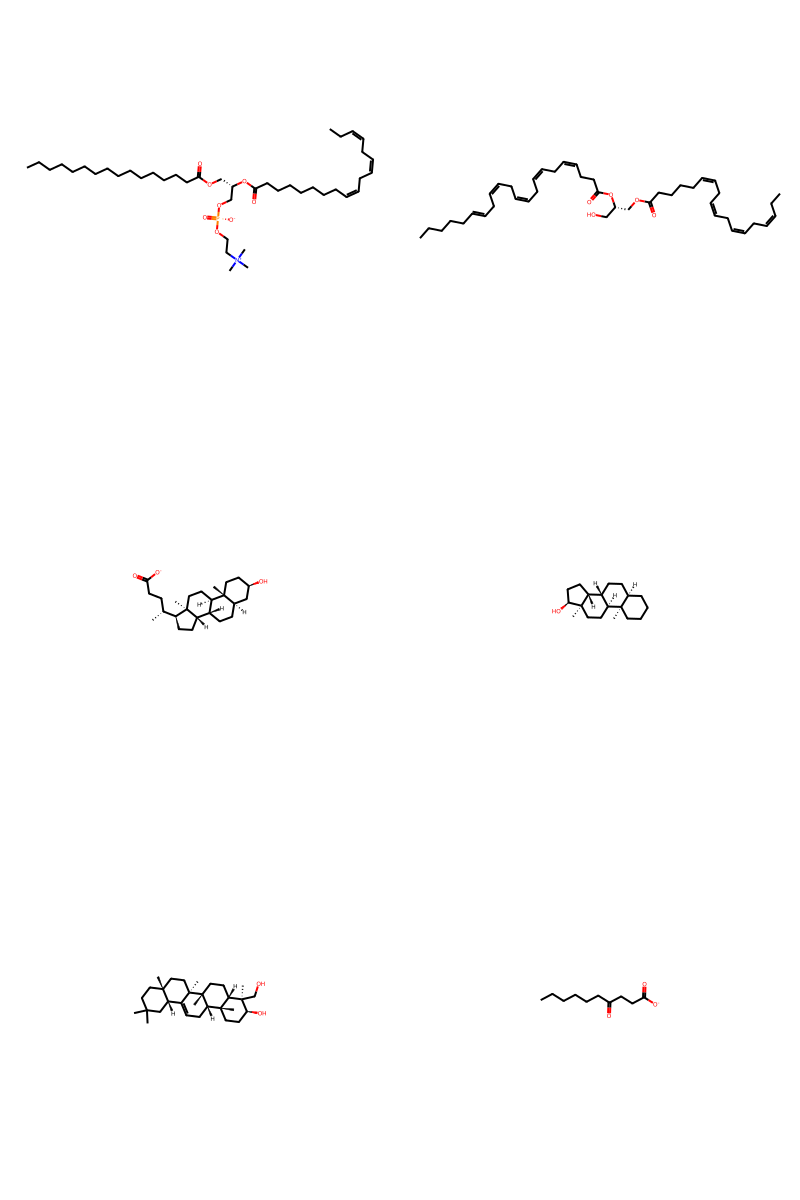

In [92]:
# Get scored smiles for ZINC
zinc_smiles_scores = get_likeness_scores(
    dataset_path=os.path.join(results_path, "data", "test_set", "zinc_meta.csv"),
    results_path=results_path,
    load_model=os.path.join(results_path, "model.tar"),
    load_config=os.path.join(results_path, "config.json"),
    input_fingerprints_path=os.path.join(results_path, "data", "test_set", "zinc_fingerprints.csv")
)

zinc_smiles_scores.sort(key=lambda x: x[2])
zinc_min_scores = zinc_smiles_scores[:6] 
zinc_max_scores = zinc_smiles_scores[-6:] 

min_score_zinc_mols = [Chem.MolFromSmiles(score_tuple[1]) for score_tuple in zinc_min_scores]
max_score_zinc_mols = [Chem.MolFromSmiles(score_tuple[1]) for score_tuple in zinc_max_scores]

Chem.Draw.MolsToGridImage(min_score_zinc_mols, molsPerRow=2, subImgSize=(400, 400))

And, finally, the ZINC structures that are the least metabolite-like. Again, these have structures and/or elements that are not aligned with metabolite structures. 

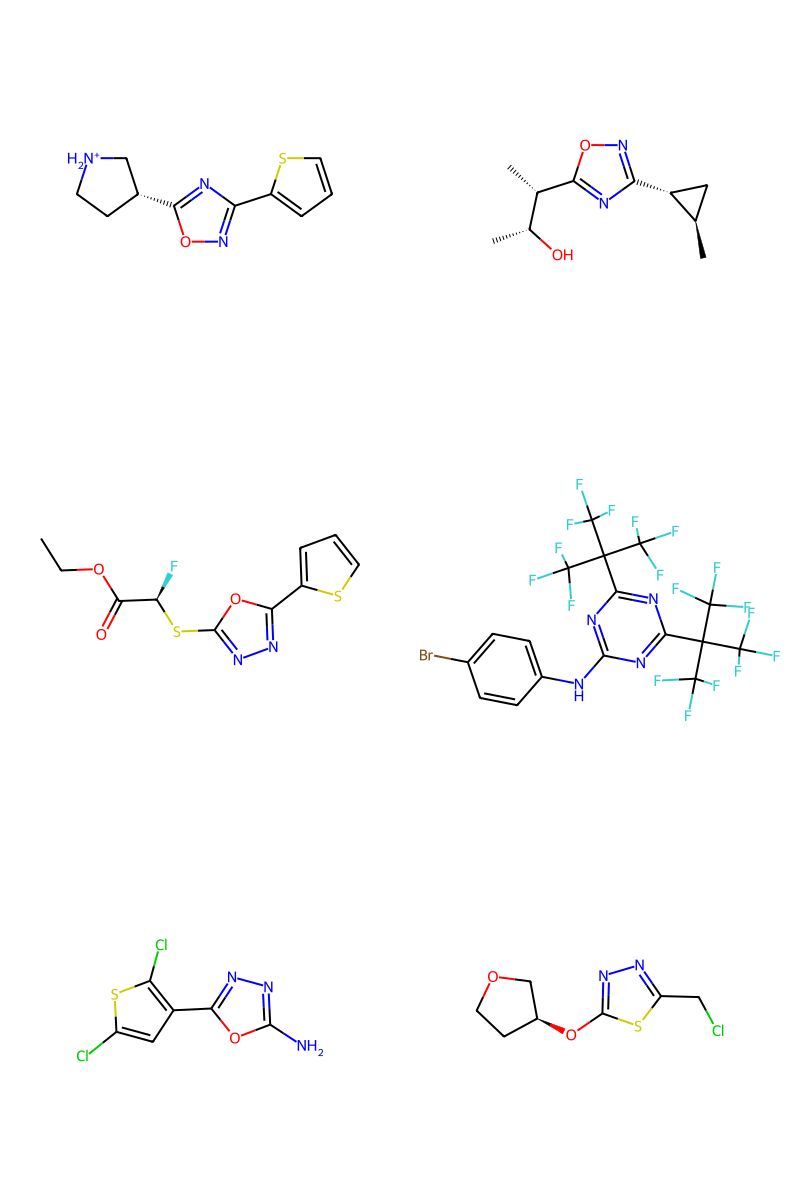

In [93]:
Chem.Draw.MolsToGridImage(max_score_zinc_mols, molsPerRow=2, subImgSize=(400, 400))

## Limitations

This project was developed for my MSc dissertation project. Given further development time, I would have addressed some of the limitations and additional work listed below.

 * **Model optimisation**: A systematic approach was applied (i.e., random grid search) to optimise model parameters. However, there were additional parameters that could have been considered. Additionally, we could have used a more "intelligent" optimisation approach, such as Optuna. Additionally, we could have considered further model architectures.
 
 * **Optimisation function**: The model was developed based on the validation set loss for the normal set. While this was sufficient to achieve reasonable model performance, we may have been able to improve it by considering the ability of the model to differentiate the normal and non-normal subsets, although could have biased the model towards a particular "non-normal" dataset.

 * **Data processing**: The data processing functions are overcomplicated and could have perhaps been bundled into a single data loader rather than the current approach that first necessitates the application of multiple data processing stages.

 * **Input features**: Molecular fingerprinting was used to describe the metabolites and other chemicals. While convenient, this might lose information compared to other approaches, such as those based directly on molecular graphs. Furthermore, the existing approach suffers from low interpretability.